In [1]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

sns.set(rc={'figure.figsize':(12,5)})

PATH_TO_DATA = "./audioset_music_genres/"


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_summary(training_summary, time_summary=None):
    if time_summary is not None:
        print(
            "Training time: "
            f"{datetime.timedelta(seconds=time_summary.training_time)}(HH:MM:SS)"
        )
        print(
            "Epoch time avg: "
            f"{datetime.timedelta(seconds=np.mean(time_summary.epoch_times))}(HH:MM:SS)"
        )

    history = pd.DataFrame(training_summary.history, index=training_summary.epoch)
    metrics = history.columns[~history.columns.str.startswith("val_")]

    fig, axes = plt.subplots(
        len(metrics), 1, sharex="all", figsize=(6, len(metrics) * 3)
    )
    for m, ax in zip(metrics, axes):
        m_val = f"val_{m}"
        if m_val in history:
            history[[m, m_val]].plot(ax=ax, style="-o")
            ax.legend(["Training set", "Validation set"])
        else:
            history[[m]].plot(ax=ax, style="-o")
            ax.legend(["Training set"])
        ax.set_xlabel("Epoch")
        ax.set_ylabel(m)
        ax.set_title(m)
        # ax.set_ylim(bottom=0, top=1.0)

# Explore meta-data

In [3]:
metadata = pd.read_csv(os.path.join(PATH_TO_DATA, 'metadata.csv'))
metadata = (metadata.rename(columns={'display_name': 'class'})
                    .assign(length=lambda d: d['end_seconds'] - d['start_seconds']))

print(f"classes: {', '.join(metadata['class'].unique())}")
print(f"Nr records: {len(metadata)}")
metadata.head()


classes: Hip hop music, Ambient music, Dubstep, Salsa music, Rock music, Soul music, Soundtrack music, House music, Gospel music
Nr records: 59585


,YTID,start_seconds,end_seconds,mid,class,id,length
0,--1rvyPa8UM,40.0,50.0,/m/0glt670,Hip hop music,865216f041fb7073f77685e588a25bcc,10.0
1,--obVyYWq6c,50.0,60.0,/m/0glt670,Hip hop music,c513363866c15d9d7f857dde799bbae5,10.0
2,-02F7gRGYHw,170.0,180.0,/m/0glt670,Hip hop music,06a7fcc0c0b11409a8d4559dbb1d5351,10.0
3,-0DdLm4S2ls,10.0,20.0,/m/0glt670,Hip hop music,0aaadc9f80b4fc9eded290a07e3e3895,10.0
4,-0G0ddCf6rY,190.0,200.0,/m/0glt670,Hip hop music,6dcc866564a540dbd00a07bd9dd6daf7,10.0


In [4]:
available_files = [file.split('.wav')[0] for file in os.listdir(f'./{PATH_TO_DATA}')]
print(f"Nr of availble files: {len(available_files)}")

metadata_df = metadata.loc[metadata['id'].isin(available_files), :]

Nr of availble files: 16585


In [5]:
print(metadata_df.shape)

(16820, 7)


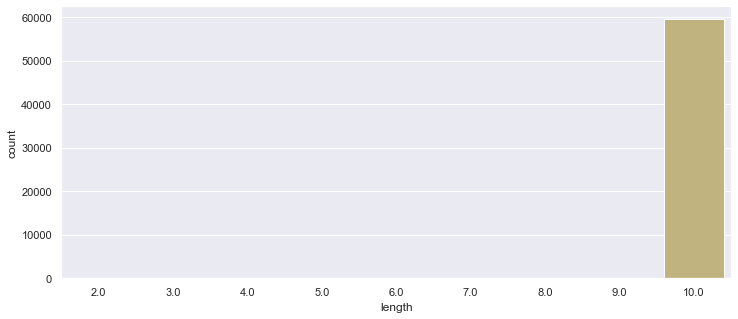

In [6]:
sns.countplot(metadata['length'])

In [7]:
# Only keep records of 10 ms
metadata_df = metadata_df[metadata_df['length'] == 10.0]

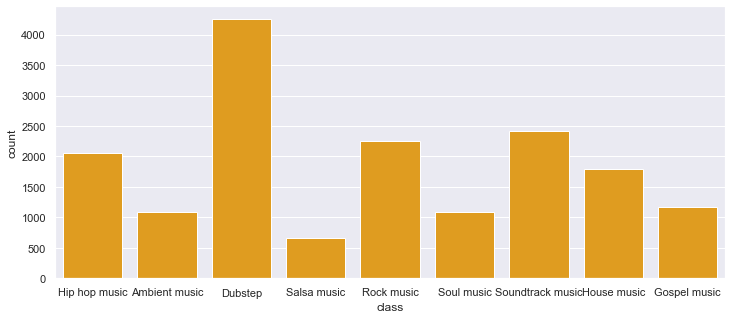

In [8]:
sns.countplot(metadata_df['class'], color='orange');

# Load music

In [9]:
wave_file_path = Path(f"{PATH_TO_DATA}/{metadata_df.iloc[0].id}.wav")
wave_file_path

PosixPath('audioset_music_genres/865216f041fb7073f77685e588a25bcc.wav')

Samples: 111088
Sampling rate: 22050
Seconds: 5.038


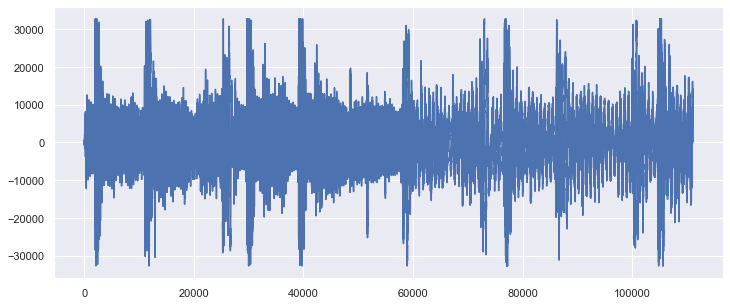

In [10]:
from scipy.io import wavfile

sampling_rate, sound_data_as_int = wavfile.read(wave_file_path)
plt.plot(sound_data_as_int)
print(f"Samples: {sound_data_as_int.shape[0]}")
print(f"Sampling rate: {sampling_rate}")
print(f"Seconds: {sound_data_as_int.shape[0] / sampling_rate:.4}")

In [11]:
from IPython.display import display, Audio

Audio(sound_data_as_int, rate=sampling_rate)

# Transform data 

In [12]:
selected_classes = ["Hip hop music", "Salsa music", "Rock music"]

metadata_df = metadata_df[metadata_df['class'].isin(selected_classes)]

In [13]:
# Read data and only keep data with same length
sampling_rate_data = np.array([
    wavfile.read(f"{PATH_TO_DATA}{file_id}.wav")
    for file_id
    in metadata_df.id
])

print(f"Data in metadata file: {sampling_rate_data.shape[0]}")

clip_length = [len(x) for x in sampling_rate_data[:, 1]]
print(f"Clip length, most common: {Counter(clip_length).most_common(20)}")

print(f"Sample rate: {Counter(sampling_rate_data[:, 0])}")
sampling_rate = np.unique(sampling_rate_data[:, 0])[0]

Data in metadata file: 4973
Clip length, most common: [(220500, 2441), (425, 213), (496, 149), (220464, 116), (220489, 104), (111088, 98), (110576, 77), (220144, 77), (220016, 74), (220080, 66), (111600, 62), (220208, 59), (220272, 57), (220336, 47), (220400, 45), (220048, 42), (155120, 38), (112112, 37), (220565, 32), (113648, 29)]
Sample rate: Counter({22050: 4973})


In [ ]:
# Take all samples of 10 seconds
SELECTED_LENGTH = 220500

selected_x = sampling_rate_data[np.array(clip_length) == SELECTED_LENGTH, 1]
selected_y = metadata_df['class'][np.array(clip_length) == SELECTED_LENGTH]

In [14]:
# Only take two seconds of data
SELECTED_LENGTH = 4 * sampling_rate

clip_length_reduced = np.array([
    x[:SELECTED_LENGTH]
    for x 
    in sampling_rate_data[:, 1]
])


selected_x = clip_length_reduced[np.array(clip_length) >= SELECTED_LENGTH]
selected_y = metadata_df['class'][np.array(clip_length) >= SELECTED_LENGTH]

In [15]:
from scipy.signal import resample

def downsample(audio, new_rate: int=8000):
    
    # Number of seconds in signal X
    secs = len(audio) / float(sampling_rate)
    # Number of samples to downsample
    samps = int(secs * new_rate)
    return resample(audio, samps)

selected_x = [
    downsample(x, 8000)
    for x
    in selected_x
]

X = np.stack(selected_x, axis=0)

In [16]:
from sklearn.preprocessing import OneHotEncoder

# One hot encoding for y-values
encoder = OneHotEncoder()

y = encoder.fit_transform(np.array(selected_y).reshape(-1, 1)).todense()

In [17]:
np.save("x_length_4s_downsampled_8000_3classes", X)
np.save("y_length_4s_downsampled_8000_3classes", y)

In [16]:
X = np.load("x_length_3s_downsampled_11025.npy", allow_pickle=True,)
y = np.load("y_length_3s_downsampled_11025.npy", allow_pickle=True,)

## Train test split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [19]:
# Further split to get a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

## Handle class imbalance

In [20]:
print(Counter(selected_y))

Counter({'Rock music': 2073, 'Hip hop music': 1895, 'Salsa music': 619})


### Resample

In [116]:
# Random oversampling of most common class
from sklearn.utils import resample

selected_count = 1800

resampled = []
y_resampled = []
for i in range(len(np.unique(selected_y))):
    X_one_class = X_train[np.where(np.argmax(y_train, axis=1) == i)[0]]
    X_one_class_resampled = resample(X_one_class, n_samples=selected_count)
    resampled.append(X_one_class_resampled)
    
    y_one_class = y_train[np.where(np.argmax(y_train, axis=1) == i)[0]]
    y_one_class_resampled = resample(y_one_class, n_samples=selected_count)
    y_resampled.append(y_one_class_resampled)
    
X_train = np.concatenate(resampled)
y_train = np.concatenate(y_resampled)

In [117]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

### Resample using tf datasets

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [21]:
import tensorflow as tf

n_classes = len(np.unique(selected_y))

BUFFER_SIZE = 100000
BATCH_SIZE = 32

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

In [37]:

def create_resampled_ds(X, y):
    datasets = []

    for i in range(n_classes):
        X_one_class = X[np.where(np.argmax(y, axis=1) == i)[0]]
        y_one_class = y[np.where(np.argmax(y, axis=1) == i)[0]]
        ds = make_ds(X_one_class, y_one_class)
        datasets.append(ds)


    return tf.data.experimental.sample_from_datasets(datasets, weights=[(1/3), (1/3), (1/3)])

resampled_ds = create_resampled_ds(X_train, y_train)
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

val_ds = create_resampled_ds(X_val, y_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

In [23]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.3333333333333333


In [47]:
# Calculate number of steps in an epoch
count_most_common_class = Counter(selected_y).most_common(1)[0][1]

resampled_steps_per_epoch = np.ceil(n_classes*float(count_most_common_class)/BATCH_SIZE)

resampled_steps_per_epoch

195.0

In [49]:
# Calculate steps in validation set
count_max_samples_val_set = np.max(np.sum(y_val, axis=0))

val_steps_per_epoch = np.ceil(n_classes*float(count_max_samples_val_set)/BATCH_SIZE)
val_steps_per_epoch

20.0

### Weights

In [110]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(metadata_df['class']), y=metadata_df['class'])

print(encoder.categories_)

class_weight_dict = {}
for i, weight in enumerate(class_weights):
    class_weight_dict[i] = weight
    
class_weight_dict

[array(['Hip hop music', 'Rock music', 'Salsa music'], dtype=object)]


{0: 0.8087804878048781, 1: 0.735581188997338, 2: 2.4746268656716417}

# Fully connected model on raw input

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

195/195 [==============================] - 10s 50ms/step - loss: 13.4404 - accuracy: 0.4481 - val_loss: 9.0998 - val_accuracy: 0.4016
Epoch 2/20
195/195 [==============================] - 8s 41ms/step - loss: 7.1430 - accuracy: 0.5901 - val_loss: 6.8085 - val_accuracy: 0.3734
Epoch 3/20
195/195 [==============================] - 7s 37ms/step - loss: 6.8419 - accuracy: 0.5691 - val_loss: 6.1480 - val_accuracy: 0.4094
Epoch 4/20
195/195 [==============================] - 7s 38ms/step - loss: 6.

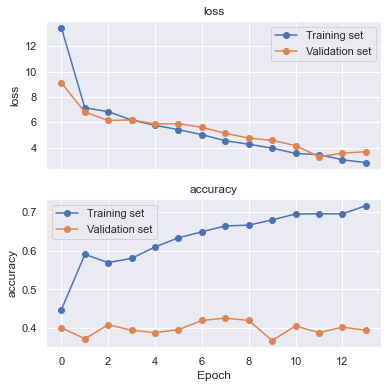

In [50]:
#### from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping


def make_model(num_categories: int):
    
    model = Sequential()
    
    l1l2 = l1_l2(l1=1e-3, l2=1e-4)
    
    model.add(BatchNormalization())
    
    model.add(Dense(name="dense_1", units=64, activation="relu", kernel_regularizer=l1l2))
    model.add(Dropout(0.2))
    
    model.add(Dense(name="dense_2", units=32, activation="relu", kernel_regularizer=l1l2))
    model.add(Dropout(0.2))
    
    model.add(Dense(name="dense_output", units=num_categories, activation="softmax"))
    
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

model_fc = make_model(y.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', # min_delta=0,
                          patience=2, verbose=0, mode='auto')

summary = model_fc.fit(resampled_ds,  
                    epochs=20, 
                    steps_per_epoch=resampled_steps_per_epoch,
                    verbose=1, 
                    validation_data=val_ds,
                    random_state=123,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[early_stopping])

plot_training_summary(summary)

In [51]:
model_fc.save('fc_audio_clf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fc_audio_clf/assets


In [52]:
from sklearn.metrics import classification_report

y_pred_test = model_fc.predict(X_test)

print(f"Test error:\n "
      f"{classification_report(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred_test, axis=1))}")

Test error:
               precision    recall  f1-score   support

           0       0.68      0.56      0.61       379
           1       0.65      0.62      0.63       415
           2       0.39      0.65      0.49       124

    accuracy                           0.60       918
   macro avg       0.57      0.61      0.58       918
weighted avg       0.63      0.60      0.61       918



In [53]:
y_pred_train = model_fc.predict(X_train)

print(f"Train error:\n " 
      f"{classification_report(y_true=np.argmax(y_train, axis=1), y_pred=np.argmax(y_pred_train, axis=1))}")

Train error:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      1705
           1       0.82      0.81      0.82      1866
           2       0.72      0.97      0.82       557

    accuracy                           0.81      4128
   macro avg       0.79      0.84      0.81      4128
weighted avg       0.81      0.81      0.81      4128



## Class weights

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

104/104 [==============================] - 3s 33ms/step - loss: 7.5295 - accuracy: 0.1523 - val_loss: 9.6545 - val_accuracy: 0.1471
Epoch 2/10
104/104 [==============================] - 3s 30ms/step - loss: 1.7507 - accuracy: 0.1344 - val_loss: 7.9140 - val_accuracy: 0.1471
Epoch 3/10
104/104 [==============================] - 3s 30ms/step - loss: 1.1183 - accuracy: 0.1338 - val_loss: 5.7792 - val_accuracy: 0.1471
Epoch 4/10
104/104 [==============================] - 3s 29ms/step - loss: 0.76

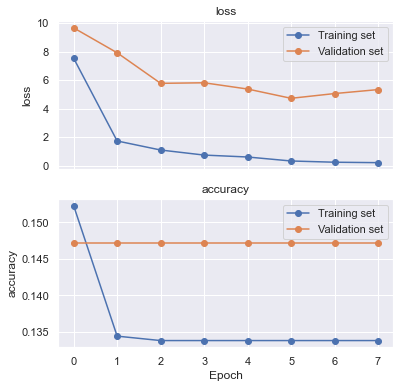

In [112]:
model_fc_weights = make_model(y.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', # min_delta=0,
                          patience=2, verbose=0, mode='auto')

summary = model_fc_weights.fit(
                    X_train,  
                    y_train, 
                    epochs=10, verbose=1, validation_split=0.1,
                    shuffle=True,
                    batch=32,
                    random_state=123,
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

plot_training_summary(summary)

In [114]:
from sklearn.metrics import classification_report

y_pred_test = model_fc_weights.predict(X_test)

print(f"Test error:\n "
      f"{classification_report(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred_test, axis=1))}")

Test error:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       379
           1       0.00      0.00      0.00       415
           2       0.14      1.00      0.24       124

    accuracy                           0.14       918
   macro avg       0.05      0.33      0.08       918
weighted avg       0.02      0.14      0.03       918



/Users/wf07pu/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# CNN on input data

Start with Conv1D layers, followed by pooling and fully connected at the end

https://github.com/drscotthawley/audio-classifier-keras-cnn/blob/master/train_network.py

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

195/195 [==============================] - 173s 888ms/step - loss: 0.9080 - accuracy: 0.5970 - val_loss: 1.1046 - val_accuracy: 0.4641
Epoch 2/20
195/195 [==============================] - 171s 878ms/step - loss: 0.5694 - accuracy: 0.7973 - val_loss: 1.0094 - val_accuracy: 0.4828
Epoch 3/20
195/195 [==============================] - 176s 904ms/step - loss: 0.3923 - accuracy: 0.8952 - val_loss: 1.0807 - val_accuracy: 0.5234
Epoch 4/20
195/195 [==============================] - 175s 895ms/step 

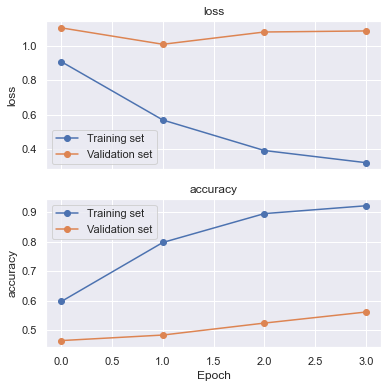

In [71]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping


def make_cnn_model(num_layers: int, n_classes: int):
    
    model = Sequential()
    
    # Input layer 
    model.add(BatchNormalization(name="InputLayer"))
    model.add(Reshape((X_train.shape[1], 1)))
    model.add(Dropout(name="Dropout_InputLayer", rate=0.3))
    
    for i in range(num_layers):
    
        # Convolutional layers (Conv2D + MaxPooling2D + Flatten + Dropout)
        model.add(
            Conv1D(
                name=f"ConvolutionalLayer_{i}",
                filters=32,
                kernel_size=3,
                activation="relu",
                padding="same",
            )
        )
        model.add(MaxPooling1D(name=f"MaxPooling_{i}"))
        
    model.add(Flatten(name=f"Flatten_{i}"))
    model.add(Dropout(rate=0.3))
    
    # Fully connected layter
    model.add(Dense(name="FullyConnectedLayer_2", units=150))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.3))
    
    # Output layter
    model.add(Dense(name="OutputLayer", units=n_classes))
    model.add(BatchNormalization())
    model.add(Activation("softmax"))

    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

model_cnn = make_cnn_model(4, n_classes=n_classes)

early_stopping = EarlyStopping(monitor='val_loss',
                          patience=2, verbose=0, mode='auto')

summary = model_cnn.fit(resampled_ds,  
                    epochs=20, 
                    steps_per_epoch=resampled_steps_per_epoch,
                    verbose=1, 
                    validation_data=val_ds,
                    random_state=123,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[early_stopping])

plot_training_summary(summary)

In [75]:
from sklearn.metrics import classification_report

y_pred_test = model_cnn.predict(X_test)

print(f"Test error:\n "
      f"{classification_report(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred_test, axis=1))}")

Test error:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       379
           1       0.79      0.90      0.84       415
           2       0.82      0.49      0.62       124

    accuracy                           0.82       918
   macro avg       0.83      0.75      0.77       918
weighted avg       0.83      0.82      0.82       918



In [76]:
y_pred_train = model_cnn.predict(X_train)

print(f"Train error:\n " 
      f"{classification_report(y_true=np.argmax(y_train, axis=1), y_pred=np.argmax(y_pred_train, axis=1))}")

Train error:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1705
           1       0.96      0.99      0.98      1866
           2       1.00      0.98      0.99       557

    accuracy                           0.98      4128
   macro avg       0.99      0.98      0.98      4128
weighted avg       0.98      0.98      0.98      4128



In [77]:
model_cnn.save("cnn_audio_clf_3classes")

INFO:tensorflow:Assets written to: cnn_audio_clf_3classes/assets


# RNN on input data

GRU: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [85]:
# Build RNN model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Reshape, GRU, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping


def make_rnn_model(n_classes: int):
    
    model = Sequential()
    
    # Input layer 
    model.add(BatchNormalization(name="InputLayer"))
    model.add(Reshape((X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    
    # RNN layers
    model.add(
        GRU(
            200, activation="relu", return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(GRU(30, activation="relu", return_sequences=False))
    model.add(Dropout(0.2))
    
    # Output layter
    model.add(Dense(name="OutputLayer", units=n_classes)) # TimeDistributed
    model.add(BatchNormalization())
    model.add(Activation("softmax"))

    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

model_rnn = make_rnn_model(n_classes=n_classes)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2, verbose=0, mode='auto')

summary = model_rnn.fit(resampled_ds,
                    epochs=20, 
                    steps_per_epoch=resampled_steps_per_epoch,
                    validation_set=val_ds,
                    validation_steps=val_steps_per_epoch,
                    verbose=1,
                    random_state=123,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

plot_training_summary(summary)


Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 

# STFT

Apply STFT (see below) to process the 1D waveform into and 2D signal (frequencies and time). If you manage to do this, try the following: 

- a. Use an RNN with multiple channels as input 
- b. Use a 2D convolution on the 2D signal.

In [ ]:
from scipy.signal import stft

sampling_rate = 11025
stft_window_size = 1024

f, t, Zxx = stft(X_train, sampling_rate, nperseg=stft_window_size)
print(f"Output of FFT is a 2D matrix of shape {Zxx.shape}, with {len(f)} frequencies and {len(t)} timesteps")

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation

def make_cnn_2d_model(n_layers: int, n_classes: int):
    
    model = Sequential()
    
    model.add(BatchNormalization(name="InputLayer"))
    model.add(Reshape((Zxx.shape[1], Zxx.shape[2], 1)))
    model.add(Dropout(name="Dropout_InputLayer", rate=0.3))
    
    for i in range(n_layers):
    
        model.add(
            Conv2D(
                name="ConvolutionalLayer_1",
                filters=32,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
            )
        )
        model.add(MaxPooling2D(name="MaxPooling_1"))
        

    model.add(Flatten(name="Flatten_1"))
    model.add(Dropout(rate=0.3))

    model.add(Dense(name="FullyConnectedLayer_2", units=150))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.3))

    model.add(Dense(name="OutputLayer", units=n_classes))
    model.add(BatchNormalization())
    model.add(Activation("softmax"))

    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

model_cnn_2d = make_cnn_2d_model(4, len(np.unique(selected_y)))

early_stopping = EarlyStopping(monitor='val_loss', # min_delta=0,
                          patience=2, verbose=0, mode='auto')

summary = model_cnn_2d.fit(
                    resampled_ds,
                    steps_per_epoch=resampled_steps_per_epoch,
                    epochs=20, 
                    verbose=1, 
                    validation_set=val_ds,
                    validation_steps=val_steps_per_epoch,
                    random_state=123,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

plot_training_summary(summary)

In [ ]:
from sklearn.metrics import classification_report

_, _, Zxx_test = stft(X_test, sampling_rate, nperseg=stft_window_size)

y_pred_test = model_cnn_2d.predict(np.expand_dims(abs(Zxx_test), axis=3))

print(f"Test error:\n "
      f"{classification_report(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred_test, axis=1))}")

In [ ]:
from sklearn.metrics import classification_report

y_pred_train = model_cnn_2d.predict(np.expand_dims(abs(Zxx), axis=3))

print(f"Train error:\n "
      f"{classification_report(y_true=np.argmax(y_train, axis=1), y_pred=np.argmax(y_pred_train, axis=1))}")